In [1]:
!pip -q install -U albumentations
!pip -q uninstall opencv-contrib-python
!pip -q install opencv-contrib-python==4.5.5.64 

     |████████████████████████████████| 113 kB 14.6 MB/s 
     |████████████████████████████████| 48.3 MB 1.7 MB/s 
Proceed (y/n)? y
     |████████████████████████████████| 66.7 MB 36 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files    # install kaggle.json
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naruto404","key":"efc2ded70d59040d686668649b6ed23c"}'}

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

 98% 265M/269M [00:05<00:00, 56.6MB/s]
100% 269M/269M [00:05<00:00, 55.0MB/s]


In [6]:
!unzip -q gender-classification-dataset.zip -d ./data/ && rm gender-classification-dataset.zip

In [7]:
%cd /content/drive/MyDrive/beauty_classification

/content/drive/MyDrive/beauty_classification


In [8]:
!ls

dataset.py  other  plots.py  __pycache__  saved  trainer.py  utils.py


In [10]:
import numpy as np

from trainer import Trainer, test_model
from utils import define_median_size, check_intensity, softmax
from plots import show_image_tensor, show_images_path
from dataset import People_dataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2 
from albumentations.augmentations import transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

In [11]:
INPUT = {'TRAIN': '../../../data/Training',
         'VALID': '../../../data/Validation'}

In [12]:
change_paths_txt = 'other/change_paths_gender.txt'
prefix = '../../..'

In [13]:
with open(change_paths_txt, 'r') as f:
    count = 0
    for line in f:
        old_path = prefix + line.split('->')[0].strip()
        new_path = prefix + line.split('->')[1].strip()

        if os.path.exists(old_path):
            os.rename(old_path, new_path)
            count += 1
    
    print(count, 'files is renamed')

169 files is renamed


In [14]:
data = {'TRAIN': {}, 'VALID': {}}

for folder in ['TRAIN', 'VALID']:
    for gender in ['female', 'male']:
        files = os.listdir(os.path.join(INPUT[folder], gender))

        paths = [os.path.join(INPUT[folder], gender, file_) for file_ in files]
        data[folder][gender] = paths

In [15]:
print('Count of female train is:', len(data['TRAIN']['female']))
print('Count of male train is:', len(data['TRAIN']['male']))
print('Count of female validation is:', len(data['VALID']['female']))
print('Count of male validation is:', len(data['VALID']['male']))

Count of female train is: 23074
Count of male train is: 23766
Count of female validation is: 5841
Count of male validation is: 5977


In [16]:
data['TRAIN']['female'].extend(data['VALID']['female'][:4000])
data['VALID']['female'] = data['VALID']['female'][4000:]

data['TRAIN']['male'].extend(data['VALID']['male'][:4000])
data['VALID']['male'] = data['VALID']['male'][4000:]

In [17]:
print('Count of female train is:', len(data['TRAIN']['female']))
print('Count of male train is:', len(data['TRAIN']['male']))
print('Count of female validation is:', len(data['VALID']['female']))
print('Count of male validation is:', len(data['VALID']['male']))

Count of female train is: 27074
Count of male train is: 27766
Count of female validation is: 1841
Count of male validation is: 1977


100%|██████████| 54840/54840 [00:03<00:00, 15174.14it/s]


Number of unique sizes is: 91
Median size is: [ 83. 107.]
Sizes are: Counter({(83, 108): 435, (81, 105): 408, (82, 107): 406, (83, 107): 396, (84, 108): 391, (84, 107): 388, (80, 105): 384, (82, 105): 384, (82, 106): 383, (85, 110): 376, (85, 111): 373, (83, 106): 373, (80, 104): 372, (82, 108): 371, (83, 109): 369, (83, 105): 368, (85, 109): 364, (83, 110): 359, (84, 109): 356, (84, 110): 354, (82, 104): 352, (82, 109): 351, (81, 106): 349, (85, 107): 343, (85, 112): 343, (84, 111): 336, (81, 104): 336, (85, 108): 331, (80, 103): 330, (86, 109): 330, (86, 111): 330, (81, 103): 330, (79, 103): 329, (84, 106): 327, (81, 107): 325, (86, 110): 325, (79, 105): 323, (80, 102): 323, (80, 107): 318, (81, 102): 317, (87, 112): 315, (86, 112): 314, (79, 102): 314, (81, 108): 313, (80, 106): 312, (80, 101): 310, (87, 111): 301, (79, 104): 300, (87, 113): 297, (86, 113): 295, (83, 104): 294, (82, 103): 287, (88, 113): 284, (78, 102): 280, (84, 112): 275, (84, 105): 275, (79, 101): 272, (87, 110):

100%|██████████| 3818/3818 [00:00<00:00, 14180.01it/s]


Number of unique sizes is: 77
Median size is: [ 83. 107.]
Sizes are: Counter({(83, 108): 38, (81, 108): 36, (78, 104): 34, (82, 107): 33, (85, 111): 32, (82, 109): 31, (83, 107): 31, (82, 105): 30, (80, 105): 29, (84, 110): 29, (84, 111): 28, (84, 106): 28, (86, 111): 28, (86, 113): 27, (81, 103): 27, (88, 113): 27, (81, 104): 27, (84, 112): 26, (79, 103): 26, (84, 108): 26, (80, 104): 26, (83, 104): 26, (86, 109): 26, (85, 107): 25, (85, 106): 25, (80, 102): 25, (87, 108): 24, (84, 107): 23, (80, 103): 23, (82, 108): 23, (79, 102): 23, (85, 110): 23, (83, 110): 23, (81, 106): 22, (83, 103): 22, (82, 101): 22, (83, 106): 22, (84, 105): 22, (81, 105): 22, (78, 102): 21, (87, 111): 21, (85, 113): 21, (81, 107): 21, (84, 109): 21, (79, 105): 21, (86, 110): 20, (85, 108): 20, (83, 105): 20, (82, 110): 20, (79, 107): 20, (83, 111): 19, (88, 110): 19, (79, 104): 19, (88, 111): 19, (87, 113): 19, (83, 109): 19, (87, 110): 19, (79, 101): 19, (80, 100): 18, (77, 103): 18, (88, 112): 18, (78, 10

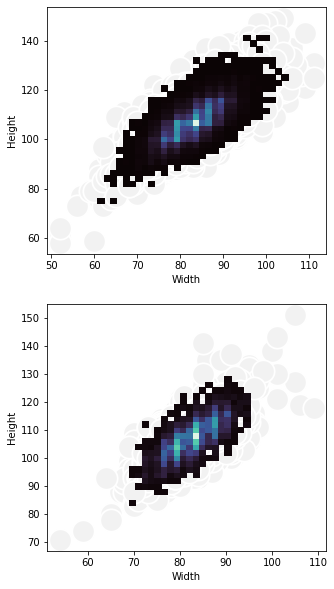

In [18]:
fig = plt.figure(figsize=(5, 10))
fig.add_subplot(2, 1, 1)
print('Median size for Train is:', define_median_size([list(data['TRAIN'].values())]), end='\n\n')

fig.add_subplot(2, 1, 2)
print('Median size for Valid is:', define_median_size([list(data['VALID'].values())]))

100%|██████████| 58658/58658 [00:03<00:00, 15977.64it/s]


Number of unique sizes is: 94
Median size is: [ 83. 107.]
Sizes are: Counter({(83, 108): 473, (82, 107): 439, (81, 105): 430, (83, 107): 427, (84, 108): 417, (82, 105): 414, (80, 105): 413, (84, 107): 411, (85, 111): 405, (82, 106): 400, (85, 110): 399, (80, 104): 398, (83, 106): 395, (82, 108): 394, (83, 109): 388, (83, 105): 388, (84, 110): 383, (83, 110): 382, (82, 109): 382, (85, 109): 381, (84, 109): 377, (81, 106): 371, (82, 104): 369, (85, 107): 368, (84, 111): 364, (81, 104): 363, (85, 112): 359, (86, 111): 358, (81, 103): 357, (86, 109): 356, (84, 106): 355, (79, 103): 355, (80, 103): 353, (85, 108): 351, (81, 108): 349, (80, 102): 348, (81, 107): 346, (86, 110): 345, (79, 105): 344, (79, 102): 337, (80, 107): 334, (81, 102): 332, (86, 112): 331, (87, 112): 330, (80, 106): 329, (80, 101): 325, (86, 113): 322, (87, 111): 322, (83, 104): 320, (79, 104): 319, (87, 113): 316, (88, 113): 311, (82, 103): 302, (84, 112): 301, (78, 102): 301, (84, 105): 297, (79, 101): 291, (85, 106):

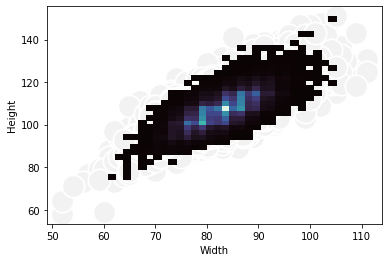

In [19]:
median_size_gender = define_median_size([list(data['TRAIN'].values()), list(data['VALID'].values())])

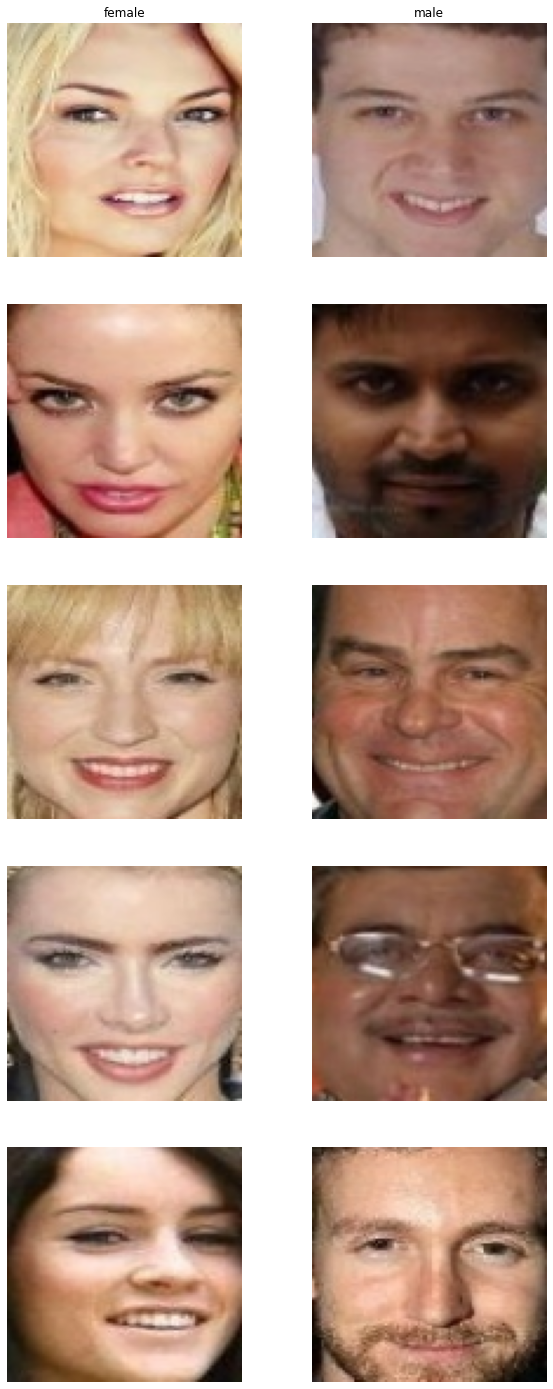

In [20]:
show_images_path([data['TRAIN']['female'][:5], data['TRAIN']['male'][:5]], resize=(100, 100), titles=['female', 'male'])

100%|██████████| 54840/54840 [00:09<00:00, 5833.96it/s]


Number of black images is: 0
Number of white images is: 0


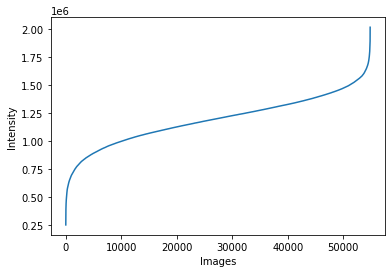

In [21]:
check_intensity(list(data['TRAIN'].values()), resize=median_size_gender)

100%|██████████| 3818/3818 [00:00<00:00, 5917.19it/s]


Number of black images is: 0
Number of white images is: 0


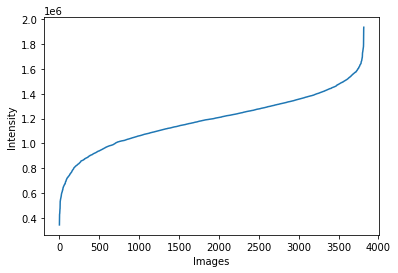

In [22]:
check_intensity(list(data['VALID'].values()), resize=median_size_gender)

In [23]:
test_aug = Compose([T.ColorJitter(p=0.3),
                    T.Equalize(p=0.3),
                    T.Flip(p=0.5),
                    T.GaussNoise(p=0.2),
                    T.HorizontalFlip(p=0.5),
                    T.RandomBrightnessContrast(p=0.3),
                    ToTensorV2()])

In [24]:
gender_dataset = People_dataset(paths=list(data['TRAIN'].values()),
                                classes=list(data['TRAIN'].keys()),
                                resize=median_size_gender,
                                transform=test_aug)

In [25]:
print('Classes is', gender_dataset.classes)

Classes is ['female', 'male']


Shape image is torch.Size([3, 107, 83])
Class is 0


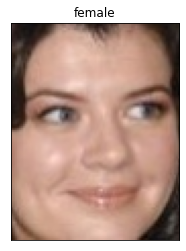

In [28]:
test_idx = 666
print('Shape image is', gender_dataset[test_idx][0].shape)
print('Class is', gender_dataset[test_idx][1])

show_image_tensor(image=gender_dataset[test_idx][0],
                  image_class=gender_dataset.classes[gender_dataset[test_idx][1]])

In [29]:
train_transform = Compose([T.ColorJitter(p=0.3),
                           T.Equalize(p=0.3),
                           T.Flip(p=0.4),
                           T.GaussNoise(p=0.2),
                           T.HorizontalFlip(p=0.4),
                           T.RandomBrightnessContrast(p=0.3),
                           ToTensorV2()])

valid_transform = Compose([T.ColorJitter(p=0.3),
                           T.Equalize(p=0.3),
                           T.Flip(p=0.4),
                           T.GaussNoise(p=0.2),
                           T.HorizontalFlip(p=0.4),
                           T.RandomBrightnessContrast(p=0.3),
                           ToTensorV2()])

test_transform = Compose([ToTensorV2()])

In [30]:
train_gender_dataset = People_dataset(paths=list(data['TRAIN'].values()),
                                      classes=list(data['TRAIN'].keys()),
                                      resize=median_size_gender,
                                      transform=train_transform)

valid_gender_dataset = People_dataset(paths=list(data['VALID'].values()),
                                      classes=list(data['VALID'].keys()),
                                      resize=median_size_gender,
                                      transform=valid_transform)

test_gender_dataset = People_dataset(paths=[data['VALID']['female'][:800], data['VALID']['male'][:800]],
                                     classes=list(data['VALID'].keys()),
                                     resize=median_size_gender,
                                     transform=test_transform)


train_loader = DataLoader(dataset=train_gender_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=1)

valid_loader = DataLoader(dataset=valid_gender_dataset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=1)

test_loader = DataLoader(dataset=test_gender_dataset,
                         batch_size=8,
                         num_workers=1)

In [31]:
def get_model(title, classes, pretrained, freeze=False):
    if title not in models.__dict__:
        print('Model is not available')
    else:
        model = models.__dict__[title](pretrained=pretrained)
    
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    
    if title in ['resnet18', 'resnet34']:
        input_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(p=0.7), nn.Linear(input_features, classes))

    elif title == 'densenet121':
        input_features = model.classifier.in_features
        model.classifier = nn.Linear(input_features, classes)

    elif title == 'mobilenet_v2':
        input_features = model.classifier[1].out_features
        model.classifier.append(nn.Linear(input_features, classes))

    return model

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, 'training')

model = get_model('resnet18', 2, pretrained=True)
model.to(device);

cuda training


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_func = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [34]:
trainer = Trainer(model=model,
                  optimizer=optimizer,
                  loss_func=loss_func,
                  num_classes=2,
                  device=device,
                  path_save='saved/gender_classification.pt')

In [36]:
epochs = 20

In [37]:
trainer.train(train_loader, valid_loader, epochs)

[1/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s, loss=0.147]


____________                                          ____________________
      Train | accuracy: 0.8856   | precision: 0.8810 |
	    | loss: 0.2760	 | recall: 0.8949    |
	      --------------------------------------
      Valid | accuracy: 0.9460   | precision: 0.9474 |
	    | loss: 0.1423	 | recall: 0.9484    |
	      --------------------------------------
__________________________________________________________________________


[2/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s, loss=0.109]


____________                                          ____________________
      Train | accuracy: 0.9479   | precision: 0.9483 |
	    | loss: 0.1447	 | recall: 0.9488    |
	      --------------------------------------
      Valid | accuracy: 0.9557   | precision: 0.9703 |
	    | loss: 0.1188	 | recall: 0.9433    |
	      --------------------------------------
__________________________________________________________________________


[3/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s, loss=0.0942]


____________                                          ____________________
      Train | accuracy: 0.9568   | precision: 0.9593 |
	    | loss: 0.1203	 | recall: 0.9552    |
	      --------------------------------------
      Valid | accuracy: 0.9625   | precision: 0.9722 |
	    | loss: 0.0953	 | recall: 0.9550    |
	      --------------------------------------
__________________________________________________________________________


[4/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.23it/s, loss=0.099]


____________                                          ____________________
      Train | accuracy: 0.9603   | precision: 0.9648 |
	    | loss: 0.1087	 | recall: 0.9566    |
	      --------------------------------------
      Valid | accuracy: 0.9612   | precision: 0.9566 |
	    | loss: 0.0990	 | recall: 0.9691    |
	      --------------------------------------
__________________________________________________________________________


[5/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s, loss=0.0757]


____________                                          ____________________
      Train | accuracy: 0.9638   | precision: 0.9684 |
	    | loss: 0.0991	 | recall: 0.9598    |
	      --------------------------------------
      Valid | accuracy: 0.9662   | precision: 0.9719 |
	    | loss: 0.0918	 | recall: 0.9626    |
	      --------------------------------------
__________________________________________________________________________


[6/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.19it/s, loss=0.104]


____________                                          ____________________
      Train | accuracy: 0.9657   | precision: 0.9709 |
	    | loss: 0.0935	 | recall: 0.9610    |
	      --------------------------------------
      Valid | accuracy: 0.9691   | precision: 0.9740 |
	    | loss: 0.0859	 | recall: 0.9661    |
	      --------------------------------------
__________________________________________________________________________


[7/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.23it/s, loss=0.0614]


____________                                          ____________________
      Train | accuracy: 0.9680   | precision: 0.9735 |
	    | loss: 0.0895	 | recall: 0.9629    |
	      --------------------------------------
      Valid | accuracy: 0.9665   | precision: 0.9743 |
	    | loss: 0.0885	 | recall: 0.9605    |
	      --------------------------------------
__________________________________________________________________________


[8/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s, loss=0.132]


____________                                          ____________________
      Train | accuracy: 0.9696   | precision: 0.9755 |
	    | loss: 0.0842	 | recall: 0.9643    |
	      --------------------------------------
      Valid | accuracy: 0.9688   | precision: 0.9789 |
	    | loss: 0.0827	 | recall: 0.9605    |
	      --------------------------------------
__________________________________________________________________________


[9/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.20it/s, loss=0.0723]


____________                                          ____________________
      Train | accuracy: 0.9705   | precision: 0.9765 |
	    | loss: 0.0808	 | recall: 0.9650    |
	      --------------------------------------
      Valid | accuracy: 0.9717   | precision: 0.9765 |
	    | loss: 0.0783	 | recall: 0.9686    |
	      --------------------------------------
__________________________________________________________________________


[10/20][valid]: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s, loss=0.11]


____________                                          ____________________
      Train | accuracy: 0.9710   | precision: 0.9774 |
	    | loss: 0.0799	 | recall: 0.9651    |
	      --------------------------------------
      Valid | accuracy: 0.9696   | precision: 0.9774 |
	    | loss: 0.0814	 | recall: 0.9636    |
	      --------------------------------------
__________________________________________________________________________


[11/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.23it/s, loss=0.0574]


____________                                          ____________________
      Train | accuracy: 0.9720   | precision: 0.9781 |
	    | loss: 0.0772	 | recall: 0.9663    |
	      --------------------------------------
      Valid | accuracy: 0.9725   | precision: 0.9800 |
	    | loss: 0.0755	 | recall: 0.9666    |
	      --------------------------------------
__________________________________________________________________________


[12/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.06it/s, loss=0.0547]


____________                                          ____________________
      Train | accuracy: 0.9730   | precision: 0.9793 |
	    | loss: 0.0742	 | recall: 0.9671    |
	      --------------------------------------
      Valid | accuracy: 0.9696   | precision: 0.9707 |
	    | loss: 0.0783	 | recall: 0.9707    |
	      --------------------------------------
__________________________________________________________________________


[13/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s, loss=0.0901]


____________                                          ____________________
      Train | accuracy: 0.9737   | precision: 0.9795 |
	    | loss: 0.0711	 | recall: 0.9683    |
	      --------------------------------------
      Valid | accuracy: 0.9741   | precision: 0.9830 |
	    | loss: 0.0736	 | recall: 0.9666    |
	      --------------------------------------
__________________________________________________________________________


[14/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s, loss=0.123]


____________                                          ____________________
      Train | accuracy: 0.9749   | precision: 0.9808 |
	    | loss: 0.0687	 | recall: 0.9695    |
	      --------------------------------------
      Valid | accuracy: 0.9696   | precision: 0.9829 |
	    | loss: 0.0786	 | recall: 0.9580    |
	      --------------------------------------
__________________________________________________________________________


[15/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, loss=0.0779]


____________                                          ____________________
      Train | accuracy: 0.9750   | precision: 0.9810 |
	    | loss: 0.0677	 | recall: 0.9693    |
	      --------------------------------------
      Valid | accuracy: 0.9707   | precision: 0.9789 |
	    | loss: 0.0743	 | recall: 0.9641    |
	      --------------------------------------
__________________________________________________________________________


[16/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s, loss=0.089]


____________                                          ____________________
      Train | accuracy: 0.9761   | precision: 0.9816 |
	    | loss: 0.0652	 | recall: 0.9709    |
	      --------------------------------------
      Valid | accuracy: 0.9686   | precision: 0.9828 |
	    | loss: 0.0823	 | recall: 0.9560    |
	      --------------------------------------
__________________________________________________________________________


[17/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s, loss=0.04]


____________                                          ____________________
      Train | accuracy: 0.9766   | precision: 0.9822 |
	    | loss: 0.0631	 | recall: 0.9713    |
	      --------------------------------------
      Valid | accuracy: 0.9733   | precision: 0.9855 |
	    | loss: 0.0789	 | recall: 0.9626    |
	      --------------------------------------
__________________________________________________________________________


[18/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.09it/s, loss=0.112]


____________                                          ____________________
      Train | accuracy: 0.9771   | precision: 0.9828 |
	    | loss: 0.0616	 | recall: 0.9717    |
	      --------------------------------------
      Valid | accuracy: 0.9717   | precision: 0.9855 |
	    | loss: 0.0777	 | recall: 0.9595    |
	      --------------------------------------
__________________________________________________________________________


[19/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s, loss=0.0637]


____________                                          ____________________
      Train | accuracy: 0.9770   | precision: 0.9823 |
	    | loss: 0.0624	 | recall: 0.9721    |
	      --------------------------------------
      Valid | accuracy: 0.9701   | precision: 0.9799 |
	    | loss: 0.0780	 | recall: 0.9621    |
	      --------------------------------------
__________________________________________________________________________


[20/20][valid]: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s, loss=0.0987]



____________                                          ____________________
      Train | accuracy: 0.9789   | precision: 0.9840 |
	    | loss: 0.0570	 | recall: 0.9741    |
	      --------------------------------------
      Valid | accuracy: 0.9691   | precision: 0.9754 |
	    | loss: 0.0812	 | recall: 0.9646    |
	      --------------------------------------
__________________________________________________________________________


In [38]:
model = torch.load('saved/gender_classification.pt', map_location=device)['model']
model.eval();

In [39]:
epochs = len(trainer.history['Train']['loss'])

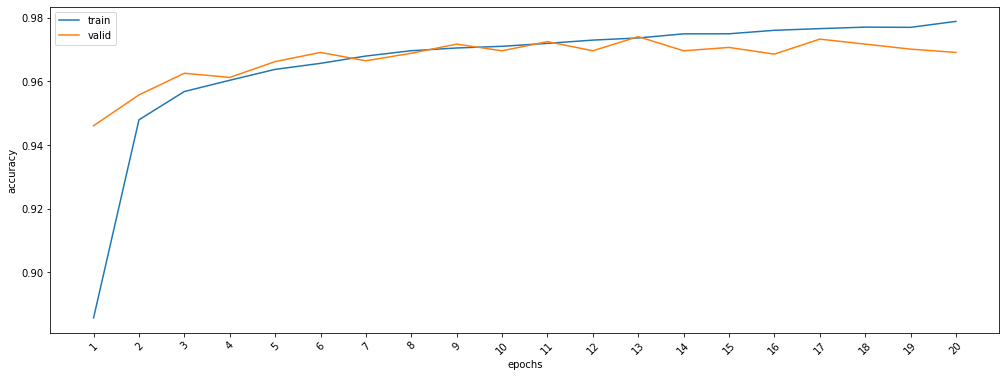

In [40]:
plt.figure(figsize=(17, 6))
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['accuracy'],
             label='train')

sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Valid']['accuracy'],
             label='valid')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xticks(range(1, epochs + 1), rotation=45)
plt.legend()

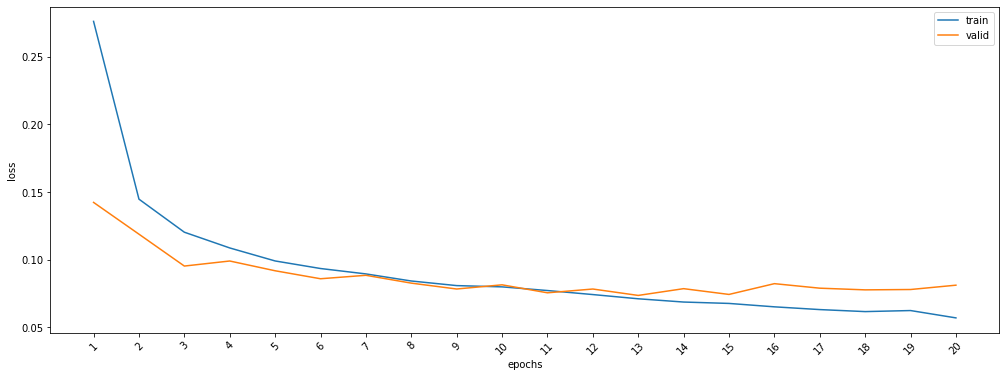

In [41]:
plt.figure(figsize=(17, 6))
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['loss'],
             label='train')

sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Valid']['loss'],
             label='valid')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xticks(range(1, epochs + 1), rotation=45)
plt.legend()

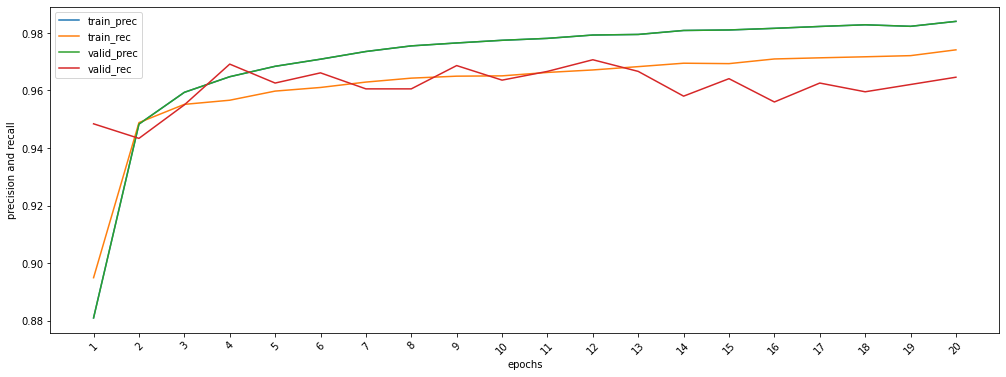

In [42]:
plt.figure(figsize=(17, 6))
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['precision'],
             label='train_prec')
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['recall'],
             label='train_rec')

sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['precision'],
             label='valid_prec')
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Valid']['recall'],
             label='valid_rec')

plt.xlabel('epochs')
plt.ylabel('precision and recall')
plt.xticks(range(1, epochs + 1), rotation=45)
plt.legend()

In [43]:
preds_data = test_model(model, test_loader, device)

100%|██████████| 200/200 [00:02<00:00, 83.13it/s]


accuracy: 0.979375


In [44]:
preds_data.sort(key=lambda pred: pred[3][0])

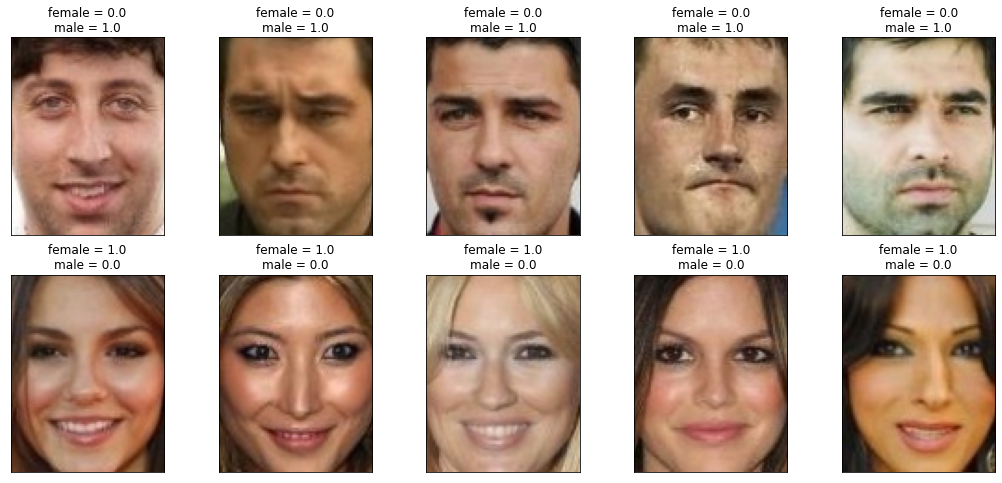

In [50]:
fig = plt.figure(figsize=(18, 8))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    
    if i >= 5:
        i = -i

    show_image_tensor(image=preds_data[i][0],
                      classes_names=['female', 'male'],
                      probality_classes=preds_data[i][3],
                      sep='\n')

In [51]:
incorrect_preds = [sample for sample in preds_data if sample[1] != sample[2]]
print('Number of samples on test_loader is', len(test_loader.dataset))
print('Number of dataset errors on test_loader is', len(incorrect_preds))

Number of samples on test_loader is 1600
Number of dataset errors on test_loader is 33


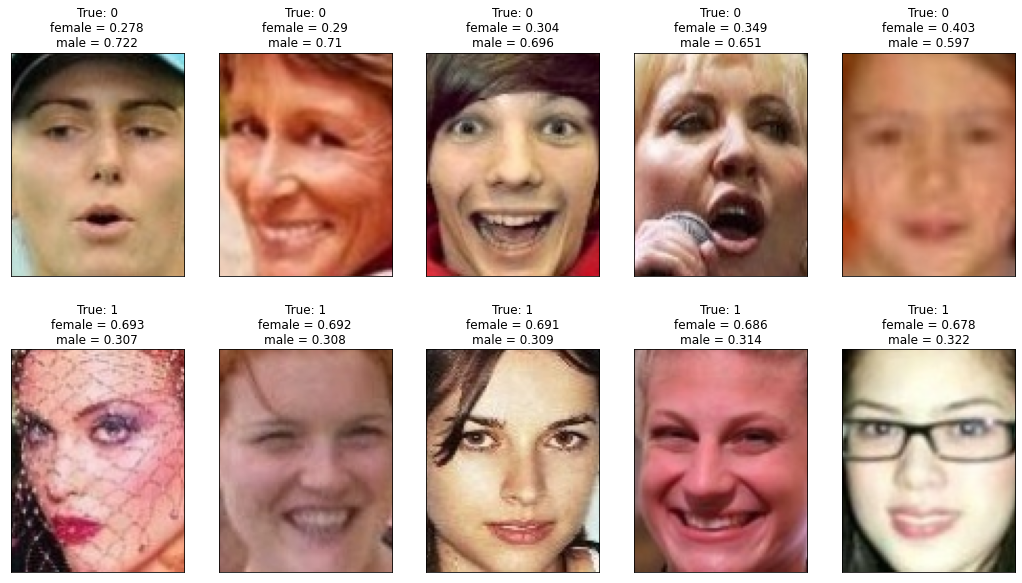

In [54]:
fig = plt.figure(figsize=(18, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    
    if i >= 5:
        i = -i

    show_image_tensor(image=incorrect_preds[i][0],
                      image_class = 'True: ' + str(incorrect_preds[i][2].item()),
                      classes_names=['female', 'male'],
                      probality_classes=softmax(incorrect_preds[i][3]),
                      sep='\n')

In [ ]:
################ Dataset fix

In [ ]:
full_gender_dataset = People_dataset(paths=[data['TRAIN']['female'] + data['VALID']['female'],
                                            data['TRAIN']['male'] + data['VALID']['male']],
                                     classes=list(data['TRAIN'].keys()),
                                     resize=median_size_gender,
                                     transform=test_transform)


full_loader = DataLoader(dataset=full_gender_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)

In [ ]:
def check_dataset(model, full_loader, device):
    incorrect_preds = []
    corrects_pred = 0

    for idx, (image, target) in enumerate(tqdm(full_loader)):
        torch.cuda.empty_cache()
        image = image.to(device)

        pred = model(image).cpu()
        _, pred = torch.max(pred, 1)
        corrects_pred += (pred[0] == target[0]).item()

        if pred[0] != target[0]:
            path = full_loader.dataset.paths[idx]
            incorrect_preds.append((path, image[0], pred[0], target[0]))
    
    print('\naccuracy:', corrects_pred / len(full_loader.dataset))
    return incorrect_preds

preds_data = check_dataset(model, full_loader, device)

In [ ]:
print('Preds for checking is', len(preds_data))
incorrect_paths = []

In [ ]:
from IPython.display import clear_output
print('Сorresponds?')

for i in range(len(preds_data)):              # If they are equel then press the y
    show_image_tensor(image=preds_data[i][1],
                      image_class=f'Pred: {full_loader.dataset.classes[preds_data[i][2].item()]}')
    plt.show()
    clear_output(True)
    key = input('[y/n]: ')

    if key == 'y':
        incorrect_paths.append(preds_data[i][0])

In [ ]:
print('Number of changed paths is', len(incorrect_paths))

In [ ]:
path_for_save_changes = 'other/change_paths_gender.txt'  #  Change paths

for path in incorrect_paths:
    old_path = path
    new_path = path.split('/')

    for i, part in enumerate(new_path):
        if part == 'female':
            new_path[i] = 'male'
            break
        if part == 'male':
            new_path[i] = 'female'
            break
    new_path = '/'.join(new_path)

    with open(path_for_save_changes, 'a') as f:
        f.write(old_path + ' -> ' + new_path + '\n')

In [ ]:
#######################